# Implementing a GP prior on Gamma

I'm going to try and implement a Gaussian Process prior on $\Gamma$ as done by Guy in his previous examples.

The relation found by Appourchaux+14 doesn't quite have a functional form but does have structure that could we bell approximated by a GP.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u

import corner
import pystan
import pickle
import os

Lets read in a handful of modes

In [4]:
locs = np.genfromtxt('locs.txt')
mid = int(np.floor(len(locs)/2))
l0s = locs[mid:mid+1,0]
l2s = locs[mid-1:mid,2]
modelocs = np.append(l0s, l2s)
modeids = [0]*len(l0s)  + [2]*len(l2s)

In [5]:
ff = np.genfromtxt('freqs.txt')
pp = np.genfromtxt('model.txt')
sel = [(ff >= np.min(modelocs)-25) & (ff <= np.max(modelocs+25))]
f = ff[tuple(sel)]
p = pp[tuple(sel)] 

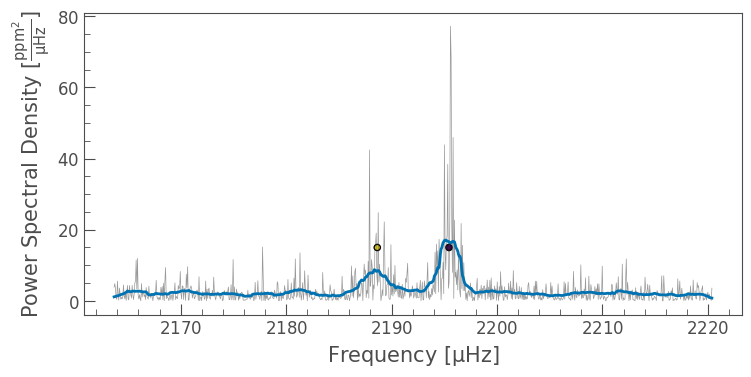

In [6]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=20, edgecolor='k')
plt.show()

## Treating $\Gamma$

According to Appourchaux et al. 2014, we can describe the linewidth $\Gamma$ as:

$\ln(\Gamma) = (\alpha\ln(\nu/\nu_{\rm max}) + \ln\Gamma_\alpha) + \Large(\frac{\ln\Delta\Gamma_{\rm dip}}{1 + \Large(\frac{2\ln(\nu/\nu_{\rm dip})}{\ln(W_{\rm dip}/\nu_{\rm max}\Large)}\Large)^2}\Large)$

where we in principle have a power law tweaked by the location of a dip in the power law at $\nu_{\rm dip}$.

Instead of fitting this complex relation, we'll use a Gaussian Process and marginalise over all functions in existence, and apply this as the prior on the linewidth.

To approximate this relation we will use a squared exponential kernel:

$K_{i, j} = \alpha^2 \times \exp\left(\frac{-(\nu_i - \nu_j)^2}{2\rho^2}\right)$

where $\nu$ is the frequency and $K$ is the GP kernel, $\alpha$ is the spread and $\rho$ is the length scale. Note that I'm using the same language as the Stan User manual (some other implementations might call these $\sigma$ and $L$ respectively).

We're going to allow $\alpha$ to vary, but we'll keep $\rho$ fixed to $2\Delta\nu$ for now. I dont think we expect it to vary much more heavily past that point.

We will set the mean of the GP to 1 for now, but ideally would like this centered at a power law, or it will bias our linewidths to a single value. -> *Update*: I think I'm just going to keep this to one.

In [ ]:
overwrite = True
gpgamma = '''
functions{      
    vector lorentzian(real loc, int l, int m, vector f, real eps, real H, real w, real nus){
        return (eps * H) ./ (1 + (4/w^2) * square(f - loc + m*nus));
    }
}
data{
    int N;            // Number of data points
    int M;            // Number of modes
    vector[N] f;      // Frequency
    vector[N] p;      // Power
    real asy_locs[M]; // Mode locations (this will have to change for multiple n modes)
    int asy_ids[M];   // The ID's of the modes
}
parameters{
    real logAmp[M];         // Mode amplitude in log space
    vector<lower=0.>[M] w;  // Mode linewidth
    real locs[M];           // True mode locations
    real<lower=0> vsini;    //  Sin of angle of inclination x rotational splitting
    real<lower=0> vcosi;    //  Cos of angle of inclination x rotational splitting
    real<lower=0.1> b;      // Background
    real<lower=0.> alpha;   // Spread on the squared exponential kernel
    real<lower=0.> rho;     // The length scale of the GP Gamma prior

}
transformed parameters{
    real H[M];                // Mode height
    real i;          // Angle of inclination (rad)
    real<lower=0> nus;     // Rotational frequency splitting
    
    nus = sqrt(vsini^2 + vcosi^2); //Calculate the splitting
    i = acos(vcosi / nus);         // Calculate the inclination
    
    for (m in 1:M){
        H[m] = 10^logAmp[m] / pi() / w[m]; // Transform mode amplitude to mode height
    }
}
model{
    vector[N] modes; // Our Model
    matrix[4,4] eps; // Matrix of legendre polynomials
    matrix[M,M] gpw; // Covariance Matrix of the linewidths
    int l;           // The radial degree
    
    // First we'll calculate all the legendre polynomials for this i
    eps = rep_matrix(1., 4, 4);
    eps[0+1,0+1] = 1.;
    eps[1+1,0+1] = cos(i)^2;
    eps[1+1,1+1] = 0.5 * sin(i)^2;
    eps[2+1,0+1] = 0.25 * (3. * cos(i)^2 - 1.)^2;
    eps[2+1,1+1] = (3./8.)*sin(2*i)^2;
    eps[2+1,2+1] = (3./8.) * sin(i)^4;
    eps[3+1,0+1] = (1./64.)*(5.*cos(3.*i) + 3.*cos(i))^2;
    eps[3+1,1+1] = (3./64.)*(5.*cos(2.*i) + 3.)^2 * sin(i)^2;
    eps[3+1,2+1] = (15./8.)*cos(i)^2 * sin(i)^4;
    eps[3+1,3+1] = (5./16.)*sin(i)^6;    

    
    // Generating the GP prior on linewidth
    gpw = cov_exp_quad(locs, alpha, rho) + diag_matrix(rep_vector(1e-6, M));
    
    // Generating our model
    modes = rep_vector(b, N);
    for (mode in 1:M){        // Iterate over all modes passed in
        l = asy_ids[mode];    // Identify the Mode ID
        for (m in -l:l){      // Iterate over all m in a given l
            modes += lorentzian(locs[mode], l, m, f, eps[l+1,abs(m)+1], H[mode], w[mode], nus);
        }
    }

    // Model drawn from a gamma distribution scaled to the model (Anderson+1990)
    p ~ gamma(1., 1../modes);
    
    //priors on the parameters
    logAmp ~ normal(1.5, 1.);
    locs ~ normal(asy_locs, 1);
    nus ~ normal(0.5, 1.);
    vsini ~ uniform(0,nus);

    
    alpha ~ normal(2.5, 1.);
    rho ~ normal(250., 50.);
    w ~ multi_normal(rep_vector(1.,M), gpw);
    
    b ~ normal(1.,.1);
}
'''
model_path = 'gpgamma.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = gpgamma, model_name='gpgamma')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()
if os.path.isfile(model_path):
    print('Reading in Stan model')
    sm = pickle.load(open(model_path, 'rb'))
else:
    print('Saving Stan Model')
    sm = pystan.StanModel(model_code = gpgamma, model_name='gpgamma')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL gpgamma_ce062b44e101872bc774fb0aadc74430 NOW.


Updating Stan model


In [7]:
nus = 0.411 #uHz
i = np.deg2rad(56.) #rad
dnu = 102. #uHz

data = {'N':len(f),
        'M': len(modelocs),
        'f':f,
        'p':p,
        'asy_locs':modelocs,
        'asy_ids':modeids}

init = {'logAmp' :   np.ones(len(modelocs))*1.5,
        'w' : np.ones(len(modelocs)),
        'vsini' : nus*np.sin(i),
        'vcosi' : nus*np.cos(i),
        'i' : i,
        'nus': nus,
        'locs' : modelocs,
        'alpha':2.5,
        'rho':250.,
        'b':1.}

In [ ]:
nchains = 4
fit = sm.sampling(data=data, iter=2000, chains=nchains,verbose=False, init = [init for n in range(nchains)])

In [ ]:
print(fit)

In [ ]:
fit.plot(pars=['vsini','vcosi','i','nus','H','logAmp','w','alpha'])
plt.show()

In [ ]:
truths= [init['vsini'],init['vcosi'],init['i'],init['nus'], np.nan, np.nan]
labels=['vsini','vcosi','i','nus', 'b', 'alpha']
chain = np.array([fit[label] for label in labels])
corner.corner(chain.T, labels=labels, quantiles=[0.16, 0.5, 0.84],
            truths=truths,show_titles=True)
plt.show()

for idx in range(len(fit['H'].T)):
    chain = np.array([fit['H'].T[idx], fit['w'].T[idx]])
    corner.corner(chain.T, labels=['H','w'], quantiles=[0.16, 0.5, 0.84],show_titles=True)
    print('l = {}'.format(modeids[idx]))   
    plt.show()

In [ ]:
def get_epsilon(i, l, m):
#I use the prescriptions from Gizon & Solank 2003 and Handberg & Campante 2012
    if l == 0:
        return 1
    if l == 1:
        if m == 0:
            return np.cos(i)**2
        if np.abs(m) == 1:
            return 0.5 * np.sin(i)**2
    if l == 2:
        if m == 0:
            return 0.25 * (3 * np.cos(i)**2 - 1)**2
        if np.abs(m) ==1:
            return (3/8)*np.sin(2*i)**2
        if np.abs(m) == 2:
            return (3/8) * np.sin(i)**4
    if l == 3:
        if m == 0:
            return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
        if np.abs(m) == 1:
            return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
        if np.abs(m) == 2:
            return (15/8) * np.cos(i)**2 * np.sin(i)**4
        if np.abs(m) == 3:
            return (5/16)*np.sin(i)**6
    
def lorentzian(f, l, m, loc, i, H, w, nus):
    eps = get_epsilon(i,l,m)
    model = eps * H / (1 + (4/w**2)*(f - loc + m * nus)**2)
    return model

model = np.ones(len(f))
nus = np.median(fit['nus'])
for mode in range(len(modeids)):
    l = modeids[mode]
    for m in range(-l, l+1):
        loc = np.median(fit['locs'].T[mode])
        H = np.median(fit['H'].T[mode])
        w = np.median(fit['w'].T[mode])
        model += lorentzian(f, l, m, modelocs[mode], i, H, w, nus)
fitlocs = np.median(fit['locs'],axis=0)

In [ ]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5, label='Data')
plt.scatter(fitlocs, [15]*len(fitlocs),c=modeids,s=20)
plt.scatter(modelocs, [15]*len(modelocs),c='r')
plt.plot(f, model, linewidth=1, label='Model')
plt.legend()

In [ ]:
def kernel(x, y, p):
    ''' Returns a sqaured exponetial covariance matrix '''
    # p[0] = sigma
    # p[1] = length scale
    return p[0]**2 * np.exp(-0.5 * np.subtract.outer(x, y)**2 / p[1]**2)    

def predict(t_2, t_1, kernel, theta, a, c, y_1, y_v):
    B = kernel(t_1, t_2, theta).T
    A = kernel(t_1, t_1, theta).T + np.diag(y_v)
    C = kernel(t_2, t_2, theta).T
    
    y = c + np.dot(np.dot(B, np.linalg.inv(A)), (y_1 - a))
    Sigma = C - np.dot(np.dot(B, np.linalg.inv(A)),B.T)
            
    y_pred = y 
    sigma_new = np.sqrt(np.diagonal(Sigma))
    return y_pred, sigma_new

def plot_GP(ax, t_1, t_2, y_1, s, y_pred, sigmas, label='Observation'):
    ax.fill_between(t_2, y_pred-sigmas, y_pred+sigmas, alpha=.5, color='#8d44ad')
    ax.plot(t_2, y_pred, c='k')
    ax.errorbar(t_1, y_1, yerr=s, fmt='o', capsize=0, label=label)
    ax.legend(fontsize=15)
    ax.set_ylabel(r'Linewidth [$\mu Hz$]', fontsize=20)
    ax.set_xlabel(r'Frequency [$\mu Hz$]', fontsize=20)
    ax.legend(fontsize=20)
    return ax

ws = np.median(fit['w'], axis=0)
ws_std = np.std(fit['w'],axis=0)
flocs = np.median(fit['locs'], axis=0)
alpha = np.median(fit['alpha'])
rho = init['rho']

npts = 500

a = np.ones(len(flocs))
c = np.ones(npts)

flocs2 = np.linspace(np.min(flocs), np.max(flocs), npts)

theta = [alpha, rho]
ws_pred, sigmas = predict(flocs2, flocs, kernel, theta, a, c, ws, ws_std**2)

fig, ax = plt.subplots(figsize=(12,8))
ax = plot_GP(ax, flocs, flocs2, ws, ws_std, ws_pred, sigmas)